In [1]:
from torch import nn
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import tqdm

from cpe import CPE, Callback
from cpe import mnist


/home/pythonian23/anaconda3/envs/CPE/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/pythonian23/anaconda3/envs/CPE/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104warnERKNS_7WarningE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


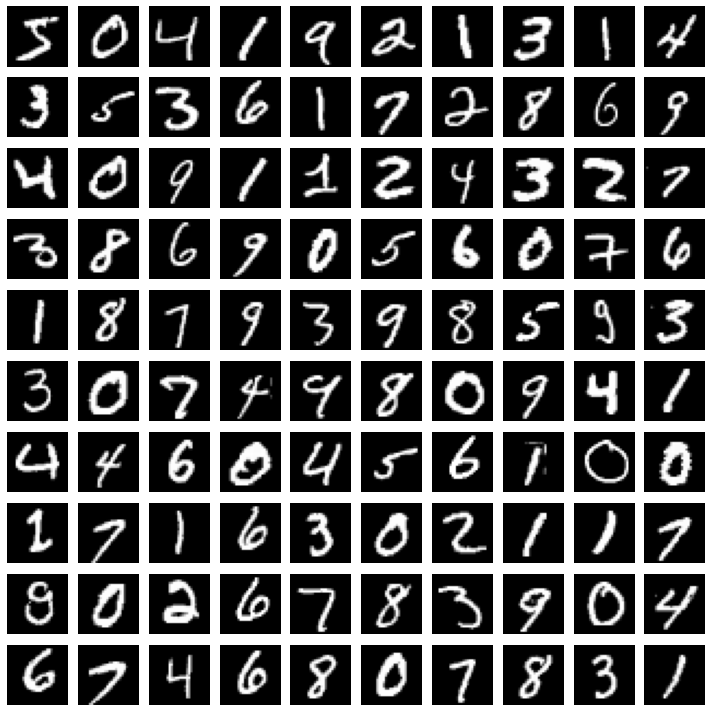

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dataset = MNIST(root="/mnt/external/pytorch_datasets/", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(dataset[i][0].squeeze(), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [3]:
generator = mnist.Generator(100).to(device)
discriminator = mnist.Discriminator().to(device)
encoder = mnist.Encoder(100).to(device)
critereon = nn.BCELoss().to(device)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
cpe = CPE(encoder, generator, discriminator, 100, device)

In [4]:
class GANCallback(Callback):
    def __init__(self, z, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.z = z
    
    def on_epoch_end(self, epoch: int, model: nn.Module, epochs_iterator: tqdm.notebook.tqdm_notebook | range):
        if epoch % 1 == 0:
            generated = model.generator(self.z).detach().cpu()
            plt.figure(figsize=(20, 1))
            for i in range(20):
                plt.subplot(1, 20, i + 1)
                plt.imshow(generated[i].squeeze(), cmap="gray")
                plt.axis("off")
            plt.tight_layout()
            plt.show()



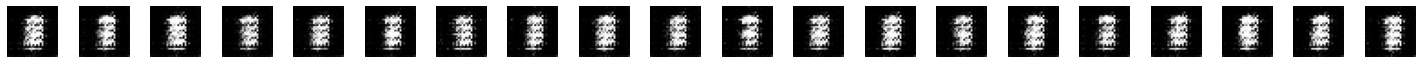

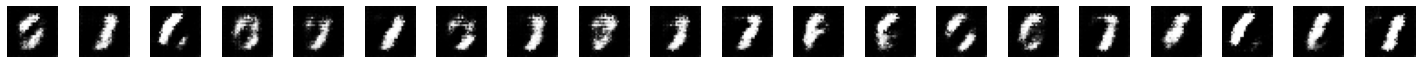

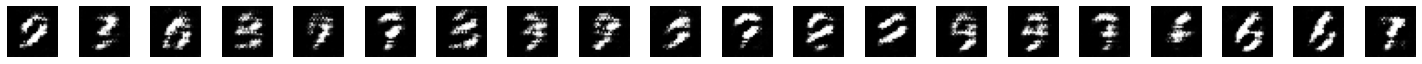

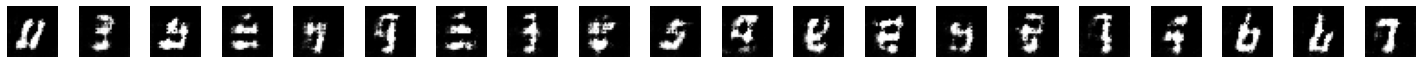

KeyboardInterrupt: 

In [5]:
z = cpe.generate_z(20)

cpe.train_gan(500, critereon, g_optimizer, d_optimizer, dataloader, callback=GANCallback(z), use_tqdm=0)

torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

In [ ]:
generator.load_state_dict(torch.load("generator.pth"))
e_optimizer = torch.optim.Adam(encoder.parameters())
e_critereon = nn.MSELoss()

In [ ]:
plt.figure(figsize=(10, 10))

z = cpe.generate_z(100)
generated = generator(z).detach().cpu()

for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(generated[i].squeeze(), cmap="gray")
    plt.axis("off")

In [ ]:
val_dataset = MNIST(root="/mnt/external/pt_datasets/", train=False, transform=transform, download=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=True)

In [ ]:

losses = []


class EncoderCallback(Callback):
    def __init__(self, criterion, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.criterion = criterion
    
    def on_epoch_end(self, epoch: int, model: nn.Module, epochs_iterator: tqdm.notebook.tqdm_notebook | range):
        z = model.generate_z(1024)
        generated = model.generator(z)
        restored = model.encoder(generated)
        loss = self.criterion(restored, z)
        losses.append(loss.item())
        if epoch % 20 == 0:
            validation_batch = next(iter(val_dataloader))[0].to(device)
            z = model.encoder(validation_batch)
            generated = model.generator(z)
            plt.figure(figsize=(20, 2))
            for i in range(20):
                plt.subplot(2, 20, i + 1)
                plt.imshow(validation_batch[i].squeeze().detach().cpu(), cmap="gray")
                plt.axis("off")
                plt.subplot(2, 20, i + 21)
                plt.imshow(generated[i].squeeze().detach().cpu(), cmap="gray")
                plt.axis("off")
            plt.show()

In [ ]:
cpe.train_encoder(100, 1024, 50, e_critereon, e_optimizer, callback=EncoderCallback(nn.MSELoss()), use_tqdm=0)
torch.save(encoder.state_dict(), "encoder.pth")

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
encoder.load_state_dict(torch.load("encoder.pth"))
generator.load_state_dict(torch.load("generator.pth"))

RESULTS = 10

generator.eval()
encoder.eval()
sign_swap = lambda x, k: x * torch.sign(k)
key = cpe.generate_z(RESULTS)
alt_key = cpe.generate_z(RESULTS)
pt = next(iter(val_dataloader))[0][:RESULTS].to(device)
pte = encoder(pt)
cte = sign_swap(pte, key)
ct = generator(cte)
alt_cte = sign_swap(pte, alt_key)
alt_ct = generator(alt_cte)
pter = sign_swap(encoder(ct), key)
ptr = generator(pter)
ptwr = sign_swap(encoder(ct), alt_key)
ptw = generator(ptwr)

pto_images = pt.detach().cpu().numpy().squeeze()
cto_images = ct.detach().cpu().numpy().squeeze()
alt_cto_images = alt_ct.detach().cpu().numpy().squeeze()
ptr_images = ptr.detach().cpu().numpy().squeeze()
ptw_images = ptw.detach().cpu().numpy().squeeze()


plt.figure(figsize=(5, RESULTS))
cols = ["Original\n", "Encrypted\n", "Encrypted\nAlt Key", "Decrypted\n", "Decrypted\nWrong Key"]
for i in range(RESULTS):
    plt.subplot(RESULTS, 5, 5 * i + 1)
    plt.imshow(pto_images[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[0])
    plt.subplot(RESULTS, 5, 5 * i + 2)
    plt.imshow(cto_images[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[1])
    plt.subplot(RESULTS, 5, 5 * i + 3)
    plt.imshow(alt_cto_images[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[2])
    plt.subplot(RESULTS, 5, 5 * i + 4)
    plt.imshow(ptr_images[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[3])
    plt.subplot(RESULTS, 5, 5 * i + 5)
    plt.imshow(ptw_images[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[4])
plt.tight_layout()
plt.savefig("results.png", transparent=False)
plt.show()